### Load Model From Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Path of Saved Models

In [2]:
## Move to root directory
!ls
%cd drive/MyDrive/Machine\ Learning/GitHub\ Projects/machine-translation
!ls

## Move to models directory
%cd models/
!ls

drive  sample_data
/content/drive/MyDrive/Machine Learning/GitHub Projects/machine-translation
gitCommands.ipynb  models  notes.txt  README.md  test  train
/content/drive/MyDrive/Machine Learning/GitHub Projects/machine-translation/models
1000  2908  _about.txt	hin-eng.zip  hin.txt  modelsummary.png


In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
model_10="2908/model.h5"
model_2908=""
model_2909=""

In [5]:
reconstructed_model = keras.models.load_model(model_10)


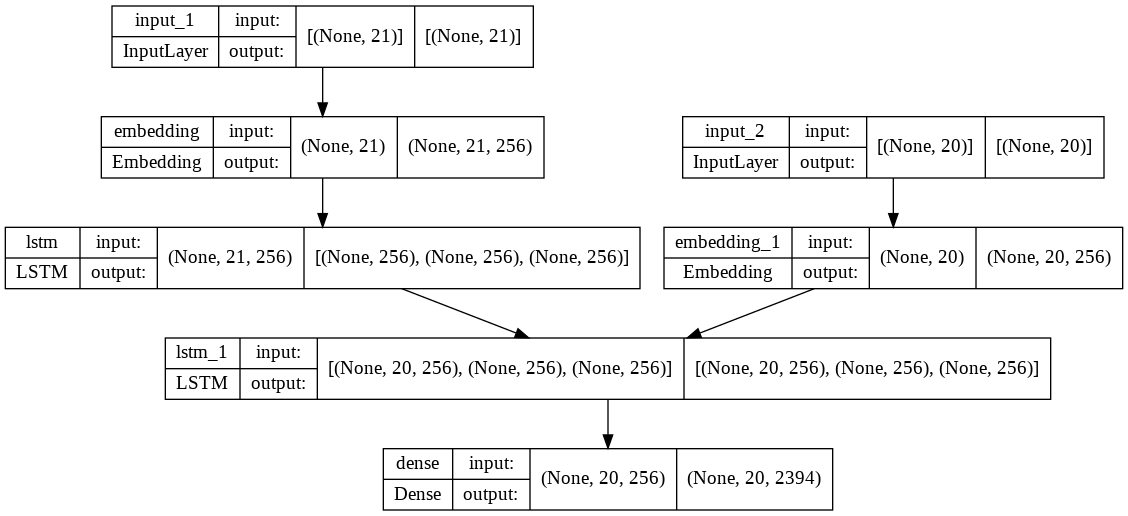

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(reconstructed_model, to_file='modelsummary.png', show_shapes=True, show_layer_names=True)

In [7]:
reconstructed_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 256)      770816      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 256)      612864      ['input_2[0][0]']                
                                                                                              

### Load Dictionaries and Parameters

In [8]:
import pickle


path_encoder_parameters='2908/parameters/encoder_parameters.pickle'
path_encoder_dictionary='2908/dictionaries/encoder_dictionary.pickle'
path_decoder_parameters='2908/parameters/decoder_parameters.pickle'
path_decoder_dictionary='2908/dictionaries/decoder_dictionary.pickle'

# loading
with open(path_encoder_parameters, 'rb') as handle:
    encoder_parameters = pickle.load(handle)

# loading
with open(path_encoder_dictionary, 'rb') as handle:
    encoder_dictionary = pickle.load(handle)

# loading
with open(path_decoder_parameters, 'rb') as handle:
    decoder_parameters= pickle.load(handle)

# loading
with open(path_decoder_dictionary, 'rb') as handle:
    decoder_dictionary = pickle.load(handle)    


In [9]:
print(encoder_parameters)
# encoder_dictionary
print(decoder_parameters)
# decoder_dictionary

{'max_encoder_seq_length': 21, 'num_encoder_tokens': 3011}
{'max_decoder_seq_length': 20, 'num_decoder_tokens': 2394}


In [10]:
encoder_inputs = reconstructed_model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = reconstructed_model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)
latent_dim = 256  # Note: may be need to save in drive as well


In [11]:
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM
from tensorflow.keras import layers , activations , models , preprocessing , utils


In [12]:
num_decoder_tokens =decoder_parameters['num_decoder_tokens']
max_output_length= decoder_parameters['max_decoder_seq_length']
max_input_length= encoder_parameters['max_encoder_seq_length']

encoder_word_dict=encoder_dictionary
decoder_word_dict= decoder_dictionary

In [13]:

decoder_inputs = Input(shape=( max_output_length , ))
decoder_embedding = Embedding( num_decoder_tokens, 256 , mask_zero=True) (decoder_inputs)

decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_dense = Dense( num_decoder_tokens , activation=tf.keras.activations.softmax ) 


In [14]:
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
          # print("word ", word, eng_word_dict.get(word,1) )
          my_word=  encoder_word_dict.get(word,1)
          tokens_list.append(my_word) 
  
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')


In [15]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


In [16]:
enc_model , dec_model = make_inference_models()

## Test Previous Model
Maybe we dont nedd the make infernece model and its attributes (above)

In [17]:
from tensorflow.keras.models import load_model


encoderPath="2908/enc_model.h5" 
decoderPath="2908/dec_model.h5"

# loading

enc_model =  load_model(encoderPath)


dec_model  =  load_model(decoderPath)

In [18]:
import numpy as np

In [19]:
for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens("मुझे खाने से प्यार है" ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = decoder_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in decoder_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print("Decoded Traslation ", decoded_translation )
    # print(f"{bcolors.OKGREEN}Decoded Traslation: { decoded_translation}{bcolors.ENDC}")


Decoded Traslation   i'm not a doctor end


# BLEU Score

### Import Library

In [20]:
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

### Import Train Data: 
#### Calculte BLEU score on train data

Function to Translate English to Hindi

In [21]:
def translate_sentence(sentence):
  for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens(sentence ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = decoder_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in decoder_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print("Decoded Traslation ", decoded_translation )
  return  decoded_translation

Import Data 

In [22]:
!wget http://www.manythings.org/anki/hin-eng.zip -O hin-eng.zip
## IIT dataset : https://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel.zip
!unzip hin-eng.zip

lines = pd.read_table( 'hin.txt' , names=[ 'eng' , 'hindi' ] )
lines.reset_index( level=0 , inplace=True )
lines.rename( columns={ 'index' : 'eng' , 'eng' : 'hindi' , 'hindi' : 'c' } , inplace=True )
lines = lines.drop( 'c' , 1 )



--2022-09-15 16:40:48--  http://www.manythings.org/anki/hin-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131711 (129K) [application/zip]
Saving to: ‘hin-eng.zip’

hin-eng.zip         100%[===================>] 128.62K  --.-KB/s    in 0.1s    

2022-09-15 16:40:48 (1.14 MB/s) - ‘hin-eng.zip’ saved [131711/131711]

Archive:  hin-eng.zip
replace hin.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hin.txt                 
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [23]:
lines.tail()

,eng,hindi
2904,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2905,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2906,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2907,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2908,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."


In [24]:
sample_sentences= lines[-10:]
sample_sentences

,eng,hindi
2899,Mother Teresa was a Catholic nun who lived and...,मदर टेरेसा एक कैथोलिक नन थीं जो कलकत्ता में रह...
2900,George Washington was the first president of t...,जार्ज वाशिंगटन संयुक्त राज्य अमेरिका के पहले र...
2901,"From my point of view, Australia is one of the...",मेरे नज़रिए से ऑस्ट्रेलिया विश्व के सर्व-श्रेष...
2902,"In 1951, Sister Teresa was sent to Calcutta, t...","१९५१ में सिस्टर टेरेसा को कलकत्ता भेजा गया था,..."
2903,Mother Teresa used the prize money for her wor...,"मदर टेरेसा को जो इनाम में पैसे मिले, उन्होंने ..."
2904,"If you go to that supermarket, you can buy mos...",उस सूपरमार्केट में तुम लगभग कोई भी रोजाने में ...
2905,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2906,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2907,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2908,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."


In [25]:
sample_sentences.index

RangeIndex(start=2899, stop=2909, step=1)

### Reference Tokens

In [26]:
reference_tokens=[]

for line in sample_sentences['eng']:
   print( line.split() ) 
   reference_tokens.append( line.split() )

['Mother', 'Teresa', 'was', 'a', 'Catholic', 'nun', 'who', 'lived', 'and', 'worked', 'in', 'Calcutta,', 'India.']
['George', 'Washington', 'was', 'the', 'first', 'president', 'of', 'the', 'Unites', 'States', 'of', 'America.']
['From', 'my', 'point', 'of', 'view,', 'Australia', 'is', 'one', 'of', 'the', 'best', 'countries', 'in', 'the', 'world.']
['In', '1951,', 'Sister', 'Teresa', 'was', 'sent', 'to', 'Calcutta,', 'then', 'the', 'largest', 'city', 'in', 'India.']
['Mother', 'Teresa', 'used', 'the', 'prize', 'money', 'for', 'her', 'work', 'in', 'India', 'and', 'around', 'the', 'world.']
['If', 'you', 'go', 'to', 'that', 'supermarket,', 'you', 'can', 'buy', 'most', 'things', 'you', 'use', 'in', 'your', 'daily', 'life.']
['The', 'passengers', 'who', 'were', 'injured', 'in', 'the', 'accident', 'were', 'taken', 'to', 'the', 'nearest', 'hospital.']
['Democracy', 'is', 'the', 'worst', 'form', 'of', 'government,', 'except', 'all', 'the', 'others', 'that', 'have', 'been', 'tried.']
['If', 'my',

In [27]:
df = pd.DataFrame(      columns=['reference', 'candidate', 'bleu_score'],  )

df["reference"]= reference_tokens

df

,reference,candidate,bleu_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...",NaN,NaN
1,"[George, Washington, was, the, first, presiden...",NaN,NaN
2,"[From, my, point, of, view,, Australia, is, on...",NaN,NaN
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...",NaN,NaN
4,"[Mother, Teresa, used, the, prize, money, for,...",NaN,NaN
5,"[If, you, go, to, that, supermarket,, you, can...",NaN,NaN
6,"[The, passengers, who, were, injured, in, the,...",NaN,NaN
7,"[Democracy, is, the, worst, form, of, governme...",NaN,NaN
8,"[If, my, boy, had, not, been, killed, in, the,...",NaN,NaN
9,"[When, I, was, a, kid,, touching, bugs, didn't...",NaN,NaN


### Candidate Tokens

In [28]:
candidate_tokens=[]


for line in sample_sentences['hindi']:
   
   result= translate_sentence(line)
   temp =result.split()
   temp= temp[:-1]
   candidate_tokens.append(temp)
   

df["candidate"]= candidate_tokens

df

Decoded Traslation   a man was thrown for a long were wrong end
Decoded Traslation   could you a doctor in end
Decoded Traslation   my father has just cleared the room of the table end
Decoded Traslation   the man woke up for a strange man end
Decoded Traslation   whoever wins the rule to the rumor say that we have a house end
Decoded Traslation   it was not to do that he went to the job end
Decoded Traslation   did the police arrest his job end
Decoded Traslation   the doctor advised that he went to the job to the party end
Decoded Traslation   my father is afraid of her grandmother end
Decoded Traslation   i don't think if i had a fight with my mother time end


,reference,candidate,bleu_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[a, man, was, thrown, for, a, long, were, wrong]",NaN
1,"[George, Washington, was, the, first, presiden...","[could, you, a, doctor, in]",NaN
2,"[From, my, point, of, view,, Australia, is, on...","[my, father, has, just, cleared, the, room, of...",NaN
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, man, woke, up, for, a, strange, man]",NaN
4,"[Mother, Teresa, used, the, prize, money, for,...","[whoever, wins, the, rule, to, the, rumor, say...",NaN
5,"[If, you, go, to, that, supermarket,, you, can...","[it, was, not, to, do, that, he, went, to, the...",NaN
6,"[The, passengers, who, were, injured, in, the,...","[did, the, police, arrest, his, job]",NaN
7,"[Democracy, is, the, worst, form, of, governme...","[the, doctor, advised, that, he, went, to, the...",NaN
8,"[If, my, boy, had, not, been, killed, in, the,...","[my, father, is, afraid, of, her, grandmother]",NaN
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[i, don't, think, if, i, had, a, fight, with, ...",NaN


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


### Calculate BLEU Score for each Sentence

In [29]:


scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):
  
   result= sentence_bleu([reference], candidate)
   scores.append(result)
  #  print( result)
 

df["bleu_score"]= scores

df

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

,reference,candidate,bleu_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[a, man, was, thrown, for, a, long, were, wrong]",8.020204e-232
1,"[George, Washington, was, the, first, presiden...","[could, you, a, doctor, in]",0.000000e+00
2,"[From, my, point, of, view,, Australia, is, on...","[my, father, has, just, cleared, the, room, of...",4.154123e-155
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, man, woke, up, for, a, strange, man]",5.116995e-232
4,"[Mother, Teresa, used, the, prize, money, for,...","[whoever, wins, the, rule, to, the, rumor, say...",9.782851e-232
5,"[If, you, go, to, that, supermarket,, you, can...","[it, was, not, to, do, that, he, went, to, the...",6.894928e-232
6,"[The, passengers, who, were, injured, in, the,...","[did, the, police, arrest, his, job]",3.068395e-232
7,"[Democracy, is, the, worst, form, of, governme...","[the, doctor, advised, that, he, went, to, the...",1.003274e-231
8,"[If, my, boy, had, not, been, killed, in, the,...","[my, father, is, afraid, of, her, grandmother]",2.326864e-232
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[i, don't, think, if, i, had, a, fight, with, ...",4.254034e-232


### Import Test Data: 
#### Calculate BLEU score on test data

# ROUGE Score

### Tensorflow Implementation

In [30]:
pip install -q "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 7.2 MB/s 


In [31]:
import tensorflow as tf
import tensorflow_text as text

In [32]:
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):
   temp =['captain', 'of', 'the', 'delta', 'flight']
   references =tf.ragged.constant([reference])
   hypotheses= tf.ragged.constant([candidate])

   result= text.metrics.rouge_l(hypotheses, references)
  
   result_str= " F-measure: "+str(result.f_measure.numpy()[0]) +"  Precision: "+str(result.p_measure.numpy()[0])+"  Recall: "+str(result.r_measure.numpy()[0])
   column=["f_measure", "p_measure", "r_measure"]
   data= [[result.f_measure.numpy()[0] ,result.p_measure.numpy()[0] , result.r_measure.numpy()[0] ]]
   metric= pd.DataFrame(data=data, columns=column)
   resultObj= {"f_measure": result.f_measure.numpy()[0] , "p_measure": result.p_measure.numpy()[0],  "r_measure":result.r_measure.numpy()[0] }  
   scores.append(resultObj)
 
 

df["rouge_score"]= scores

df

,reference,candidate,bleu_score,rouge_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[a, man, was, thrown, for, a, long, were, wrong]",8.020204e-232,"{'f_measure': 0.18181819, 'p_measure': 0.22222..."
1,"[George, Washington, was, the, first, presiden...","[could, you, a, doctor, in]",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur..."
2,"[From, my, point, of, view,, Australia, is, on...","[my, father, has, just, cleared, the, room, of...",4.154123e-155,"{'f_measure': 0.24000001, 'p_measure': 0.3, 'r..."
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, man, woke, up, for, a, strange, man]",5.116995e-232,"{'f_measure': 0.09090909, 'p_measure': 0.125, ..."
4,"[Mother, Teresa, used, the, prize, money, for,...","[whoever, wins, the, rule, to, the, rumor, say...",9.782851e-232,"{'f_measure': 0.14285715, 'p_measure': 0.15384..."
5,"[If, you, go, to, that, supermarket,, you, can...","[it, was, not, to, do, that, he, went, to, the...",6.894928e-232,"{'f_measure': 0.14285715, 'p_measure': 0.18181..."
6,"[The, passengers, who, were, injured, in, the,...","[did, the, police, arrest, his, job]",3.068395e-232,"{'f_measure': 0.1, 'p_measure': 0.16666667, 'r..."
7,"[Democracy, is, the, worst, form, of, governme...","[the, doctor, advised, that, he, went, to, the...",1.003274e-231,"{'f_measure': 0.14814816, 'p_measure': 0.16666..."
8,"[If, my, boy, had, not, been, killed, in, the,...","[my, father, is, afraid, of, her, grandmother]",2.326864e-232,"{'f_measure': 0.080000006, 'p_measure': 0.1428..."
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[i, don't, think, if, i, had, a, fight, with, ...",4.254034e-232,"{'f_measure': 0.058823533, 'p_measure': 0.0833..."


In [33]:
# Example how to use ROUGE
hypotheses = tf.ragged.constant([['captain', 'of', 'the', 'delta', 'flight'],
                                ])
references = tf.ragged.constant([['delta', 'air', 'lines', 'flight'],
                                 ])


result = text.metrics.rouge_l(hypotheses, references)
result_str= " F-measure: "+str(result.f_measure.numpy()[0]) +"\n Precision: "+str(result.p_measure.numpy()[0])+"\n Recall: "+str(result.r_measure.numpy()[0])
print('F-Measure: %s' % result.f_measure)
print('P-Measure: %s' % result.p_measure)
print('R-Measure: %s' % result.r_measure)

F-Measure: tf.Tensor([0.44444448], shape=(1,), dtype=float32)
P-Measure: tf.Tensor([0.4], shape=(1,), dtype=float32)
R-Measure: tf.Tensor([0.5], shape=(1,), dtype=float32)


### PyPi Implementation ROUGE

In [34]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=9883c6b4815de90c0ac1a5858618b87a0fffac8effe4faf085a28f18e421a85e
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [35]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

In [36]:
scores

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [37]:
scorer = rouge_scorer.RougeScorer([ 'rougeL'], use_stemmer=False)
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):

   references = " ".join(reference)  
   hypotheses=  " ".join(candidate)
 
  
   result = scorer.score(references, hypotheses)

   scores.append(result)
 
 

df["py_pi_rouge_score"]= scores

df

# Not  working as I expected. It works if I use english letters, but the score is 0 if I test with sentence  which has hindi charachters

,reference,candidate,bleu_score,rouge_score,py_pi_rouge_score
0,"[Mother, Teresa, was, a, Catholic, nun, who, l...","[a, man, was, thrown, for, a, long, were, wrong]",8.020204e-232,"{'f_measure': 0.18181819, 'p_measure': 0.22222...","{'rougeL': (0.2222222222222222, 0.153846153846..."
1,"[George, Washington, was, the, first, presiden...","[could, you, a, doctor, in]",0.000000e+00,"{'f_measure': 0.0, 'p_measure': 0.0, 'r_measur...","{'rougeL': (0.0, 0.0, 0.0)}"
2,"[From, my, point, of, view,, Australia, is, on...","[my, father, has, just, cleared, the, room, of...",4.154123e-155,"{'f_measure': 0.24000001, 'p_measure': 0.3, 'r...","{'rougeL': (0.3, 0.2, 0.24)}"
3,"[In, 1951,, Sister, Teresa, was, sent, to, Cal...","[the, man, woke, up, for, a, strange, man]",5.116995e-232,"{'f_measure': 0.09090909, 'p_measure': 0.125, ...","{'rougeL': (0.125, 0.07142857142857142, 0.0909..."
4,"[Mother, Teresa, used, the, prize, money, for,...","[whoever, wins, the, rule, to, the, rumor, say...",9.782851e-232,"{'f_measure': 0.14285715, 'p_measure': 0.15384...","{'rougeL': (0.15384615384615385, 0.13333333333..."
5,"[If, you, go, to, that, supermarket,, you, can...","[it, was, not, to, do, that, he, went, to, the...",6.894928e-232,"{'f_measure': 0.14285715, 'p_measure': 0.18181...","{'rougeL': (0.18181818181818182, 0.11764705882..."
6,"[The, passengers, who, were, injured, in, the,...","[did, the, police, arrest, his, job]",3.068395e-232,"{'f_measure': 0.1, 'p_measure': 0.16666667, 'r...","{'rougeL': (0.16666666666666666, 0.07142857142..."
7,"[Democracy, is, the, worst, form, of, governme...","[the, doctor, advised, that, he, went, to, the...",1.003274e-231,"{'f_measure': 0.14814816, 'p_measure': 0.16666...","{'rougeL': (0.16666666666666666, 0.13333333333..."
8,"[If, my, boy, had, not, been, killed, in, the,...","[my, father, is, afraid, of, her, grandmother]",2.326864e-232,"{'f_measure': 0.080000006, 'p_measure': 0.1428...","{'rougeL': (0.14285714285714285, 0.05555555555..."
9,"[When, I, was, a, kid,, touching, bugs, didn't...","[i, don't, think, if, i, had, a, fight, with, ...",4.254034e-232,"{'f_measure': 0.058823533, 'p_measure': 0.0833...","{'rougeL': (0.23076923076923078, 0.13043478260..."


### Cosine Score

Word Embedding Hindi

In [38]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.4 MB/s 
  Using cached pybind11-2.10.0-py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3161184 sha256=947a73571f8a0118a69fdadc16b1d064d5a39a88acb07534b98d25065a8ef547
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [39]:
import fasttext.util
# fasttext.util.download_model('hi', if_exists='ignore')  # Hindi
fast_text_path='/content/drive/MyDrive/Machine Learning/FastText Hindi Word Embedding/cc.hi.300.bin'



In [40]:
ft = fasttext.load_model(fast_text_path)

Def. Cosine Score

In [41]:
def cos_sim(a, b):
	"""Takes 2 vectors a, b and returns the cosine similarity according 
	to the definition of the dot product
	"""
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

In [ ]:
scorer = cos_sim
scores=[]
for reference, candidate in zip(df['reference'], df['candidate']):

   references = " ".join(reference)  
   hypotheses=  " ".join(candidate)
 
   references_vector  = ft.get_sentence_vector(references)
   hypotheses_vector  = ft.get_sentence_vector(hypotheses)

   result = scorer(references_vector, hypotheses_vector)

   scores.append(result)
 

df["cosine_similarity"]= scores

df

In [43]:
# To Get nearest neigbours
# ft.get_nearest_neighbors("कीड़ों")
# ft.get_words()

In [44]:



rouge_metric= pd.DataFrame.from_records(df['rouge_score'])

average_f_measure = rouge_metric['f_measure'].mean()
average_p_measure = rouge_metric['p_measure'].mean()
average_r_measure = rouge_metric['r_measure'].mean()
average_cosine= df['cosine_similarity'].mean()
average_bleu= df['bleu_score'].mean()

print(
" F_measure: ",average_f_measure,
"\n P_measure: ",average_p_measure,
"\n R_measure: ",average_r_measure, 
"\n Cosine: ",average_cosine,
"\n BLEU: ",average_bleu
)


 F_measure:  0.11854134 
 P_measure:  0.15424104 
 R_measure:  0.09820272 
 Cosine:  0.7966349 
 BLEU:  4.154122940232254e-156


In [45]:
table =pd.DataFrame(columns=["average_f_measure", "average_p_measure","average_r_measure", "average_cosine", "average_bleu"], data=[[average_f_measure, average_p_measure,average_r_measure, average_cosine, average_bleu]])
table

,average_f_measure,average_p_measure,average_r_measure,average_cosine,average_bleu
0,0.118541,0.154241,0.098203,0.796635,4.154123e-156
